In [ ]:
!pip install tensorflow keras numpy matplotlib scikit-learn

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download HAM10000 from Kaggle
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Unzip the dataset
!unzip -q skin-cancer-mnist-ham10000.zip -d ham10000

print("Dataset downloaded and extracted successfully!")



Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 99% 5.16G/5.20G [02:49<00:04, 8.60MB/s]
100% 5.20G/5.20G [02:49<00:00, 32.9MB/s]
Dataset downloaded and extracted successfully!


In [ ]:

import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Load metadata
df = pd.read_csv("ham10000/HAM10000_metadata.csv")

# Combine image folder paths
img_dir1 = "ham10000/HAM10000_images_part_1"
img_dir2 = "ham10000/HAM10000_images_part_2"

# Create output directories
base_dir = "ham_split"
os.makedirs(base_dir, exist_ok=True)

for split in ["train", "val", "test"]:
    for label in df["dx"].unique():
        os.makedirs(f"{base_dir}/{split}/{label}", exist_ok=True)

# Add full file path column
df["path"] = df["image_id"].apply(
    lambda x: f"{img_dir1}/{x}.jpg" if os.path.exists(f"{img_dir1}/{x}.jpg")
    else f"{img_dir2}/{x}.jpg"
)

# Train/Val/Test split
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df["dx"])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df["dx"])

# Function to copy files
def copy_files(split_df, split_name):
    for _, row in split_df.iterrows():
        src = row["path"]
        dst = f"{base_dir}/{split_name}/{row['dx']}/{os.path.basename(src)}"
        shutil.copy(src, dst)

copy_files(train_df, "train")
copy_files(val_df, "val")
copy_files(test_df, "test")

print("Dataset successfully split into train/val/test!")



Dataset successfully split into train/val/test!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "ham_split/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    "ham_split/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    "ham_split/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Generators ready!")




Found 7010 images belonging to 7 classes.
Found 1502 images belonging to 7 classes.
Found 1503 images belonging to 7 classes.
Generators ready!


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 (Pretrained on ImageNet)
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')

# Freeze base model weights
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
done

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
EPOCHS = 15

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.6040 - loss: 1.2364 - val_accuracy: 0.6951 - val_loss: 0.8579
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.6966 - loss: 0.8754 - val_accuracy: 0.7111 - val_loss: 0.7837
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.7046 - loss: 0.8296 - val_accuracy: 0.7284 - val_loss: 0.7496
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.7153 - loss: 0.7867 - val_accuracy: 0.7350 - val_loss: 0.7330
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.7224 - loss: 0.7644 - val_accuracy: 0.7383 - val_loss: 0.7282
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.7406 - loss: 0.7250 - val_accuracy: 0.7330 - val_loss: 0.7130
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.7548 - loss: 0.6986 - val_accuracy: 0.7463 - val_loss: 0.7102
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.7472 - loss: 0.6998 - val_accu

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1. Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss  : {test_loss:.4f}")
print(f"Test Acc   : {test_acc*100:.2f}%")

# 2. Predictions
y_true = test_generator.classes
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

class_labels = list(test_generator.class_indices.keys())
print("Class labels:", class_labels)

# 3. Classification report (Precision, Recall, F1)
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


47/47 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5528 - loss: 1.2751
Test Loss  : 0.7279
Test Acc   : 74.85%
47/47 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step
Class labels: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
              precision    recall  f1-score   support

       akiec       0.50      0.08      0.14        49
         bcc       0.67      0.31      0.42        77
         bkl       0.44      0.52      0.47       165
          df       0.00      0.00      0.00        17
         mel       0.44      0.50      0.47       167
          nv       0.86      0.91      0.89      1006
        vasc       0.80      0.36      0.50        22

    accuracy                           0.75      1503
   macro avg       0.53      0.38      0.41      1503
weighted avg       0.74      0.75      0.73      1503



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 800x600 with 0 Axes>

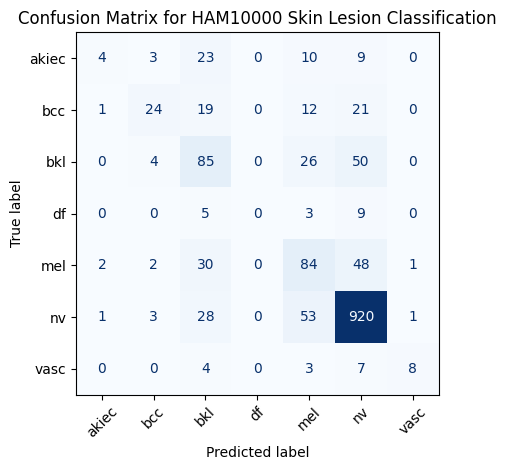

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(include_values=True, xticks_rotation=45, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix for HAM10000 Skin Lesion Classification")
plt.tight_layout()
plt.show()


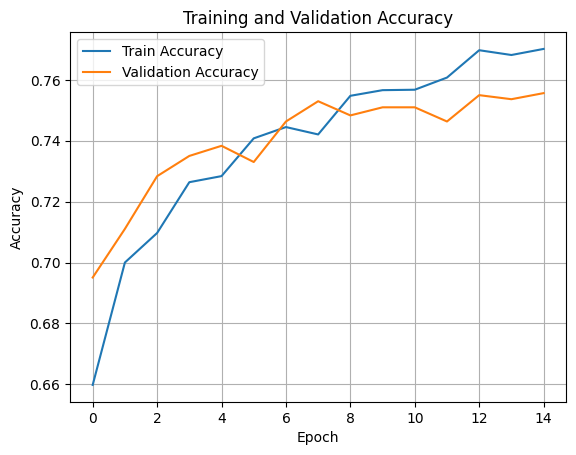

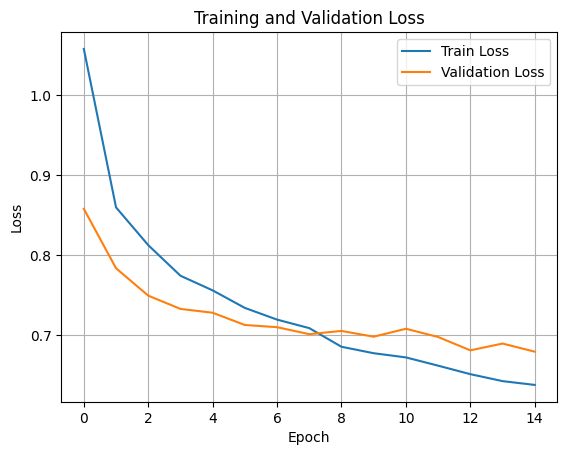

In [ ]:
# Accuracy Curves
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Curves
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
